In [1]:
!pip install tf-nightly 
import tensorflow as tf
print("Tensor Flow Verion: " + tf.__version__)
tf.test.gpu_device_name()

     |████████████████████████████████| 519.0MB 26kB/s 
     |████████████████████████████████| 3.0MB 61.0MB/s 
     |████████████████████████████████| 460kB 59.9MB/s 
Tensor Flow Verion: 2.2.0-dev20200419


'/device:GPU:0'

In [3]:
!pip install kaggle
!mkdir .kaggle
import json
token = {"username":"mingzhehu","key":"92235045fd85f95ca75fb5844cc352ff"}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /content/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/kermany2018 -p /content

mkdir: cannot create directory ‘.kaggle’: File exists
- path is now set to: {/content}
100% 10.8G/10.8G [04:17<00:00, 40.0MB/s]
100% 10.8G/10.8G [04:17<00:00, 45.2MB/s]


In [0]:
!unzip \*.zip

In [0]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D,GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt

# **MobileNet Model**

In [7]:
img_rows, img_cols = 224, 224 

# Re-loads the MobileNet model without the top or FC layers
mobile = MobileNet(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in mobile.layers:
    layer.trainable = False
    
for (i,layer) in enumerate(mobile.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

17227776/17225924 [==============================] - 0s 0us/step
0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 ReLU False
5 DepthwiseConv2D False
6 BatchNormalization False
7 ReLU False
8 Conv2D False
9 BatchNormalization False
10 ReLU False
11 ZeroPadding2D False
12 DepthwiseConv2D False
13 BatchNormalization False
14 ReLU False
15 Conv2D False
16 BatchNormalization False
17 ReLU False
18 DepthwiseConv2D False
19 BatchNormalization False
20 ReLU False
21 Conv2D False
22 BatchNormalization False
23 ReLU False
24 ZeroPadding2D False
25 DepthwiseConv2D False
26 BatchNormalization False
27 ReLU False
28 Conv2D False
29 BatchNormalization False
30 ReLU False
31 DepthwiseConv2D False
32 BatchNormalization False
33 ReLU False
34 Conv2D False
35 BatchNormalization False
36 ReLU False
37 ZeroPadding2D False
38 DepthwiseConv2D False
39 BatchNormalization False
40 ReLU False
41 Conv2D False
42 BatchNormalization False
43 ReLU False
44 DepthwiseConv2D False


In [0]:
def addTopModel(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""
    top_model = bottom_model.output
    top_model=GlobalAveragePooling2D()(top_model)
    top_model=Dense(1024,activation='relu')(top_model) 
    top_model=Dense(1024,activation='relu')(top_model) 
    top_model=Dense(512,activation='relu')(top_model) 
    top_model = Dense(num_classes, activation = "softmax")(top_model)

    return top_model

In [9]:
num_classes = 4

FC_Head = addTopModel(mobile, num_classes)

model = Model(inputs=mobile.input, outputs=FC_Head)

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [0]:
train_data_dir = '/content/OCT2017 /train'
validation_data_dir = '/content/OCT2017 /test'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
batch_size=16
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


# **Train MobileNet**

In [0]:
checkpoint_path = "train_ckpt/cp-{epoch:04d}.ckpt"

In [0]:
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

callbacks = [earlystop, checkpoint]

In [0]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr = 0.001),
              metrics = ['accuracy'])

In [0]:
nb_train_samples = 83484
nb_validation_samples = 968

epochs = 10
batch_size = 16

In [16]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
5217/5217 [==============================] - ETA: 0s - loss: 0.4050 - accuracy: 0.8544
Epoch 00001: val_loss improved from inf to 0.13304, saving model to train_ckpt/cp-0001.ckpt
INFO:tensorflow:Assets written to: train_ckpt/cp-0001.ckpt/assets
5217/5217 [==============================] - 1135s 218ms/step - loss: 0.4050 - accuracy: 0.8544 - val_loss: 0.1330 - val_accuracy: 0.9656
Epoch 2/10
5217/5217 [==============================] - ETA: 0s - loss: 0.3391 - accuracy: 0.8784
Epoch 00002: val_loss improved from 0.13304 to 0.10696, saving model to train_ckpt/cp-0002.ckpt
INFO:tensorflow:Assets written to: train_ckpt/cp-0002.ckpt/assets
5217/5217 [==============================] - 1040s 199ms/step - loss: 0.3391 - accuracy: 0.8784 - val_loss: 0.1070 - val_accuracy: 0.9604
Epoch 3/10
5217/5217 [==============================] - ETA: 0s - loss: 0.3182 - accuracy: 0.8859
Epoch 00003: val_loss did not impr

In [18]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 3s 46ms/step - loss: 0.1137 - accuracy: 0.9576

Test result: 95.764 loss: 0.114


In [19]:
!mkdir -p saved_model
model.save('saved_model/MobileNet_model') 

INFO:tensorflow:Assets written to: saved_model/MobileNet_model/assets


**Loading saved classifier**

In [0]:
model = tf.keras.models.load_model('saved_model/MobileNet_model')

**Training and validation history**

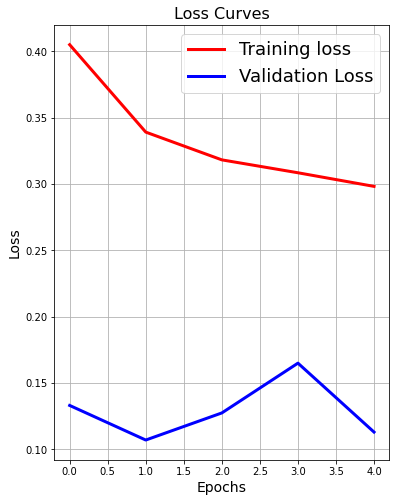

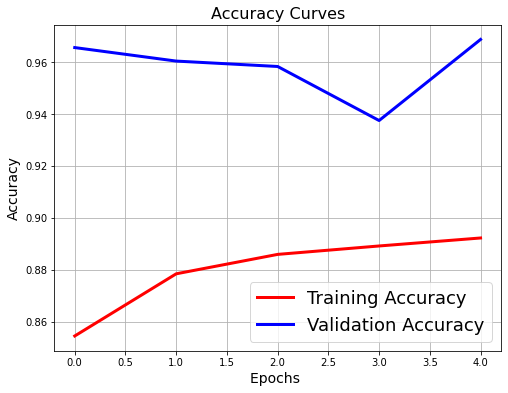

In [20]:
#Loss Curves
plt.figure(figsize=[6, 8])
plt.plot(history.history["loss"], "r", linewidth=3.0)
plt.plot(history.history["val_loss"], "b", linewidth=3.0)
plt.legend(["Training loss", "Validation Loss"], fontsize=18)
plt.grid()
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Loss Curves", fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.grid()
plt.xlabel('Epochs ',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.title('Accuracy Curves',fontsize=16);

**Test result**

In [21]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


In [0]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()} 
classes = list(class_labels.values())

In [23]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


Confusion Matrix
[[239   2   1   0]
 [  7 225   0  10]
 [ 12   2 223   5]
 [  0   0   0 242]]


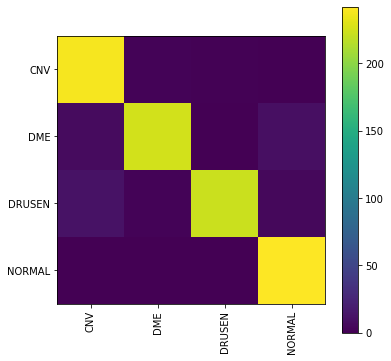

In [24]:
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [25]:
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Classification Report
              precision    recall  f1-score   support

         CNV       0.93      0.99      0.96       242
         DME       0.98      0.93      0.96       242
      DRUSEN       1.00      0.92      0.96       242
      NORMAL       0.94      1.00      0.97       242

    accuracy                           0.96       968
   macro avg       0.96      0.96      0.96       968
weighted avg       0.96      0.96      0.96       968



**Testing on Images**

In [0]:
import os
from os import listdir
from os.path import isfile, join
from google.colab.patches import cv2_imshow

In [0]:
import tensorflow.keras.preprocessing.image as preimg
import cv2

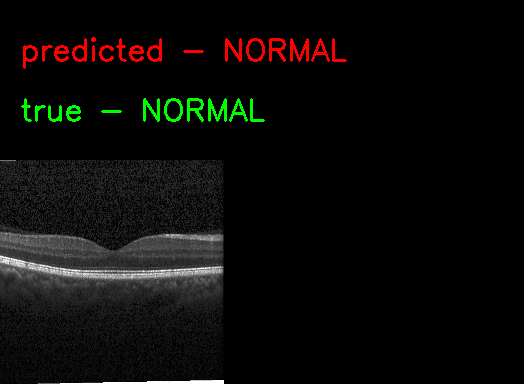

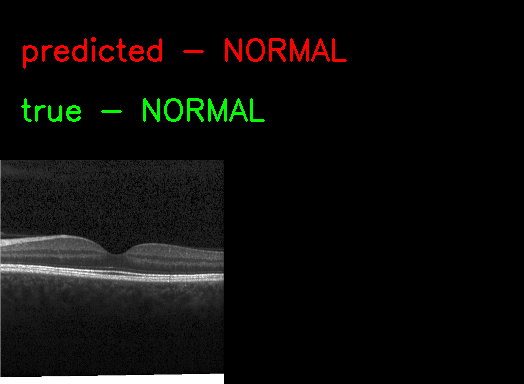

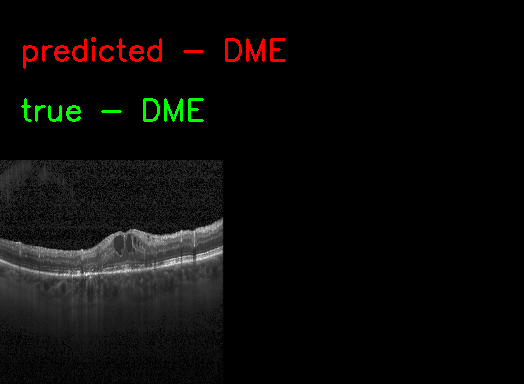

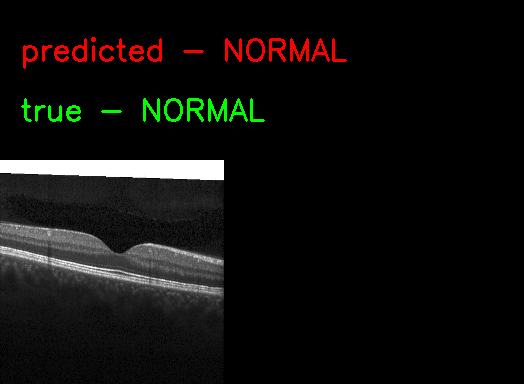

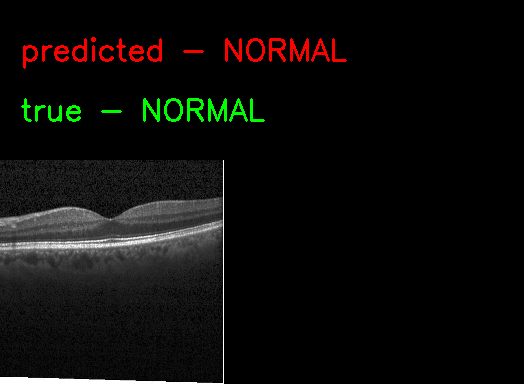

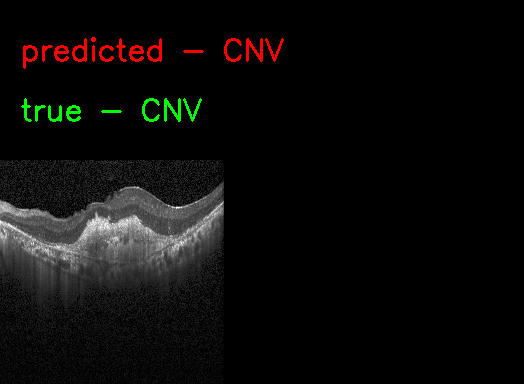

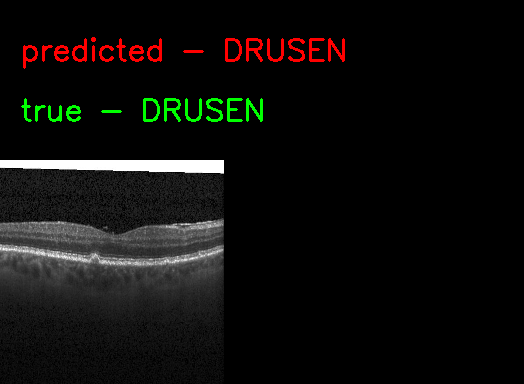

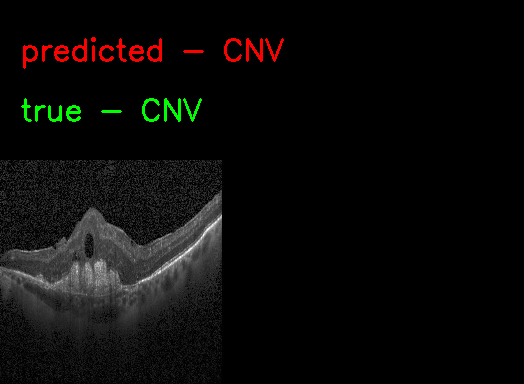

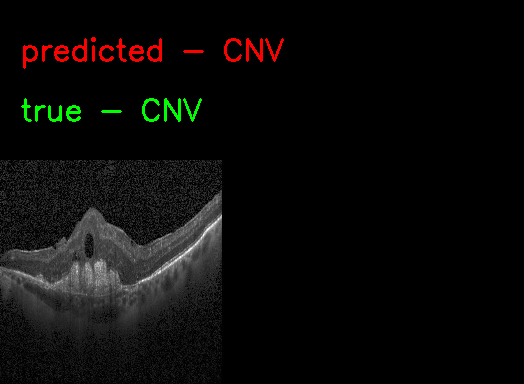

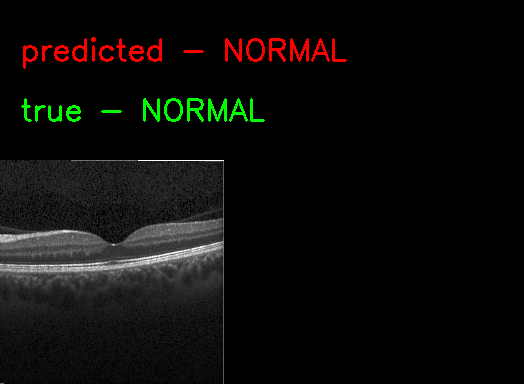

In [48]:
def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 300 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predicted - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2_imshow(expanded_image)
    

def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return preimg.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# dimensions of our images
img_width, img_height = 224, 224

files = []
predictions = []
true_labels = []

# predicting images
for i in range(0, 10):
    path = 'OCT2017 /val/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = preimg.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    predict = model.predict(images, batch_size = 10)
    classes = np.argmax(predict, axis=1)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    image = cv2.resize(image, (img_width, img_height), fx=5, fy=5, interpolation = cv2.INTER_CUBIC)
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()

**Plot the model structure**

In [0]:
from tensorflow.keras.utils import plot_model
import matplotlib.image as mpimg

(-0.5, 658.5, 10143.5, -0.5)

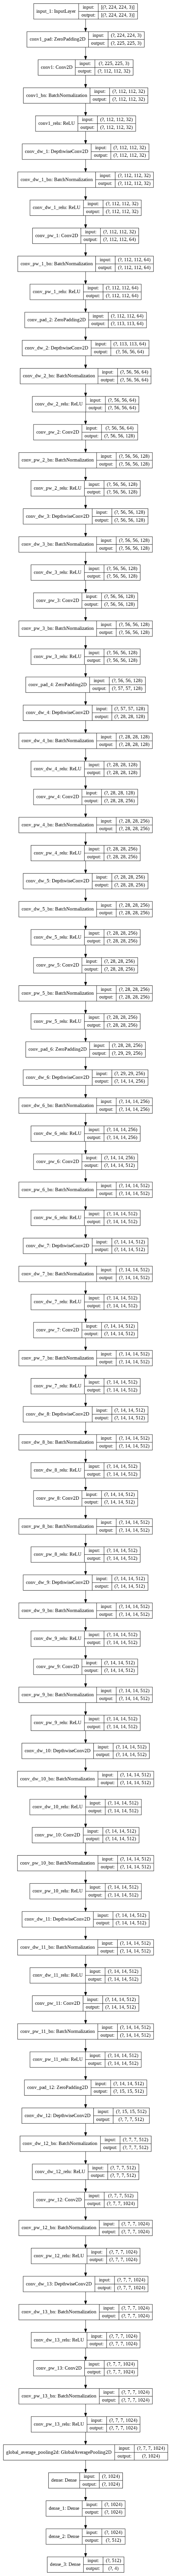

In [45]:
plot_model(model, to_file="model_plot_retinal_MobileNet.png", show_shapes=True, show_layer_names=True)
img = mpimg.imread('model_plot_retinal_MobileNet.png')
plt.figure(figsize=(45,160))
plt.imshow(img)
plt.axis("off")

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
